In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

pl.Config.set_fmt_str_lengths(200)

polars.config.Config

### Introduction

The Synthetix Perps v3 contract underwent some battle testing on base testnet from October 2nd to October 24th. Users were invited to use the platform to see how the new product worked and to give a chance for developers to find any bugs. Using the perps v3 subgraph, we can glean indepth analytics on the usage and behavior of the platform, user behavior, and market analytics. 

This part of the notebook goves over:
* first and last trade time
* trading and liquidation activity
* ...

In [2]:
perps_v3_df = pl.read_parquet("perps_v3.parquet").with_columns([
    (pl.col('size_delta').abs() * pl.col('price')).alias('size_delta_usd_abs'),
    (pl.col('size_delta') * pl.col('price')).alias('size_delta_usd')
])

In [3]:
# first and last trade
start_date = perps_v3_df.sort(by='datetime', descending=False)[0]['datetime'].item().strftime('%A, %B %d, %Y %I:%M %p')
end_date = perps_v3_df.sort(by='datetime', descending=False)[-1]['datetime'].item().strftime('%A, %B %d, %Y %I:%M %p')

print(f'first trade was on {start_date}')
print(f'last trade was on {end_date}')

first trade was on Monday, October 02, 2023 05:13 PM
last trade was on Monday, October 23, 2023 11:05 PM


In [4]:
# unique trades
trade_count = perps_v3_df.filter(pl.col('liquidation') == False).shape[0]
liquidation_count = perps_v3_df.filter(pl.col('liquidation') == True).shape[0]

print(f'there were {trade_count} orders successfully filled')
print(f'there were {liquidation_count} liquidation events')

there were 2287 orders successfully filled
there were 441 liquidation events


In [5]:
# get the overlap between unique accuonts
unique_liq_accts = perps_v3_df.filter(pl.col('liquidation') == True)['accountId'].unique().to_list()
unique_orders_accts = perps_v3_df.filter(pl.col('liquidation') == False)['accountId'].unique().to_list()

print(f'{len(unique_liq_accts)} unique accounts liquidated')
print(f'{len(unique_orders_accts)} unique accounts traded')

84 unique accounts liquidated
131 unique accounts traded


### Trades and Liquidation Trading Activity

In [6]:
# Group by datetime, count occurrences, and pivot to create a stacked DataFrame
activity_counts = (perps_v3_df
    .with_columns([pl.col('datetime').dt.round('1d').dt.strftime('%m-%d')])
    .group_by(pl.col('datetime', 'liquidation')).agg([pl.count()])
    .sort(by='datetime', descending=False)
).to_pandas()

In [7]:
activity_counts.head(5)

,datetime,liquidation,count
0,10-03,True,14
1,10-03,False,329
2,10-04,True,115
3,10-04,False,386
4,10-05,False,263


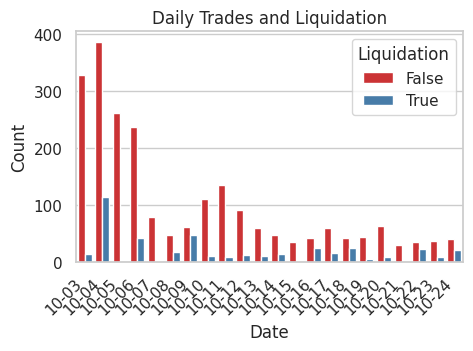

In [8]:
plt.figure(figsize=(5,3))  # Set the figure size
sns.set(style="whitegrid")  # Set the style
sns.barplot(x="datetime", y="count", hue="liquidation", data=activity_counts, palette="Set1")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Trades and Liquidation")

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.legend(title="Liquidation", loc="upper right")
plt.show()

### Market Activity

In [9]:
perp_v3_historical_markets_df = (
    pl.read_parquet("market_updates.parquet")
    .with_columns([
        pl.col('marketUpdateds_price') / 10**18,
        pl.col('marketUpdateds_currentFundingRate') / 10**18,
        pl.col('marketUpdateds_skew') / 10**18,
        pl.col('marketUpdateds_size') / 10**18,  
        pl.col('marketUpdateds_sizeDelta') / 10**18,  
        pl.col('marketUpdateds_currentFundingVelocity') / 10**18,  # ! is funding velocity 18 decimals too?
    ])
    .with_columns([
        # get usd values
        (pl.col('marketUpdateds_size') * pl.col('marketUpdateds_price')).alias('marketUpdateds_size_usd'),
        (pl.col('marketUpdateds_sizeDelta') * pl.col('marketUpdateds_price')).alias('marketUpdateds_sizeDelta_usd'),
        (pl.col('marketUpdateds_skew') * pl.col('marketUpdateds_skew')).alias('marketUpdateds_skew_usd'),
    ])
)

<Axes: xlabel='marketUpdateds_timestamp'>

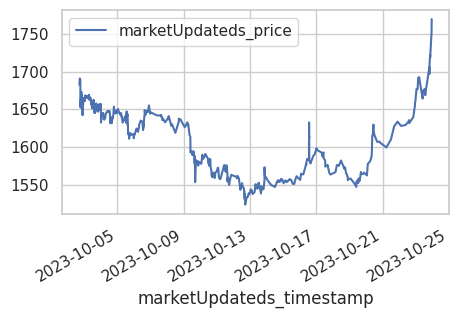

In [10]:
(
    perp_v3_historical_markets_df
    .filter(pl.col("markets_marketSymbol") == "ETH")
    .with_columns([pl.from_epoch(pl.col('marketUpdateds_timestamp'))])
    .sort(by='marketUpdateds_timestamp', descending=True)
    .to_pandas().plot(kind='line', x='marketUpdateds_timestamp', y='marketUpdateds_price', figsize=(5, 3))
)

In [11]:
eth_price_df = (
    perp_v3_historical_markets_df
    .filter(pl.col("markets_marketSymbol") == "ETH")
    .with_columns([pl.from_epoch(pl.col('marketUpdateds_timestamp')).dt.round('1h').dt.strftime('%m-%d %H:%M')])
    .group_by('marketUpdateds_timestamp').agg([pl.mean('marketUpdateds_price')])
    .sort(by='marketUpdateds_timestamp', descending=True)
    .to_pandas()
)

eth_size_df = (
    perp_v3_historical_markets_df
    .filter(pl.col("markets_marketSymbol") == "ETH")
    .with_columns([pl.from_epoch(pl.col('marketUpdateds_timestamp')).dt.round('1h').dt.strftime('%m-%d %H:%M')])
    .group_by('marketUpdateds_timestamp').agg([pl.sum('marketUpdateds_size_usd')])
    .sort(by='marketUpdateds_timestamp', descending=True)
    .to_pandas()
)

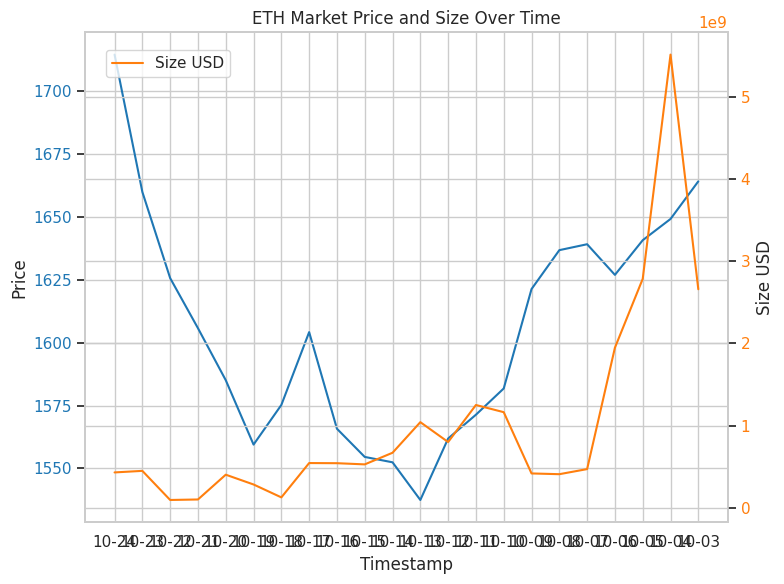

In [29]:
fig, ax1 = plt.subplots(figsize=(8, 6))  # Adjust the figsize as needed

# Plot the first line chart on the primary y-axis
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Price")
ax1.plot(eth_price_df['marketUpdateds_timestamp'], eth_price_df['marketUpdateds_price'], label='Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin axis on the secondary y-axis
ax2 = ax1.twinx()

# Plot the second line chart on the secondary y-axis
ax2.set_ylabel("Size USD")
ax2.plot(eth_size_df['marketUpdateds_timestamp'], eth_size_df['marketUpdateds_size_usd'], label='Size USD', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title("ETH Market Price and Size Over Time")
fig.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

In [13]:
perps_v3_df.head(5)

datetime,accountId,marketSymbol,size_delta,size,price,liquidation,accounts_owner,size_delta_usd_abs,size_delta_usd
datetime[μs],str,str,f64,f64,f64,bool,str,f64,f64
2023-10-23 22:48:26,"""170141183460469231731687303715884105856""","""LINK""",1234.3639,0.0,10.533,true,"""0xfc9f6bb19c91d6490d8d73f2353d395fa0892736""",13001.554959,13001.554959
2023-10-23 22:47:46,"""170141183460469231731687303715884105856""","""LINK""",19999.8,-1234.3639,10.526109,true,"""0xfc9f6bb19c91d6490d8d73f2353d395fa0892736""",210520.068978,210520.068978
2023-10-23 22:47:04,"""170141183460469231731687303715884105856""","""LINK""",19999.8,-21234.1639,10.56526,true,"""0xfc9f6bb19c91d6490d8d73f2353d395fa0892736""",211303.095948,211303.095948
2023-10-23 22:46:24,"""170141183460469231731687303715884105856""","""LINK""",19999.8,-41233.9639,10.528384,true,"""0xfc9f6bb19c91d6490d8d73f2353d395fa0892736""",210565.576323,210565.576323
2023-10-23 22:45:44,"""170141183460469231731687303715884105856""","""LINK""",19999.8,-61233.7639,10.632118,true,"""0xfc9f6bb19c91d6490d8d73f2353d395fa0892736""",212640.238176,212640.238176


In [14]:
liq_volume_usd_abs_eth = (
    perps_v3_df
    .filter(pl.col('liquidation') == True)
    .filter(pl.col('marketSymbol') == 'ETH')
    .with_columns([pl.col('datetime').dt.round('1h').dt.strftime('%m-%d %H:%M')]) # '%m-%d
    .group_by(pl.col('datetime', 'marketSymbol')).agg([pl.sum('size_delta_usd_abs')])
    .sort(by='datetime', descending=False)
).to_pandas()

In [15]:
liq_volume_usd_abs_eth.head(5)

,datetime,marketSymbol,size_delta_usd_abs
0,10-03,ETH,1.580309e+07
1,10-04,ETH,7.736247e+08
2,10-06,ETH,3.387393e+07
3,10-07,ETH,4.979406e+06
4,10-08,ETH,2.313750e+06


In [16]:
eth_size_df.head(5)

,marketUpdateds_timestamp,marketUpdateds_size_usd
0,10-24,4.294091e+08
1,10-23,4.483277e+08
2,10-22,9.431492e+07
3,10-21,1.004206e+08
4,10-20,4.018287e+08


In [17]:
merged_df = eth_size_df.rename(columns={'marketUpdateds_timestamp': 'datetime'}).merge(liq_volume_usd_abs_eth, on=['datetime'], how='left')

In [18]:
eth_size_df.shape

(22, 2)

In [19]:
liq_volume_usd_abs_eth.shape

(19, 3)

In [20]:
merged_df.shape

(22, 4)

In [21]:
plot_merged_df = merged_df[['datetime', 'marketUpdateds_size_usd', 'size_delta_usd_abs']]

In [22]:
plot_merged_df.head(5)

,datetime,marketUpdateds_size_usd,size_delta_usd_abs
0,10-24,4.294091e+08,4.673778e+07
1,10-23,4.483277e+08,5.001148e+06
2,10-22,9.431492e+07,NaN
3,10-21,1.004206e+08,NaN
4,10-20,4.018287e+08,3.833879e+06


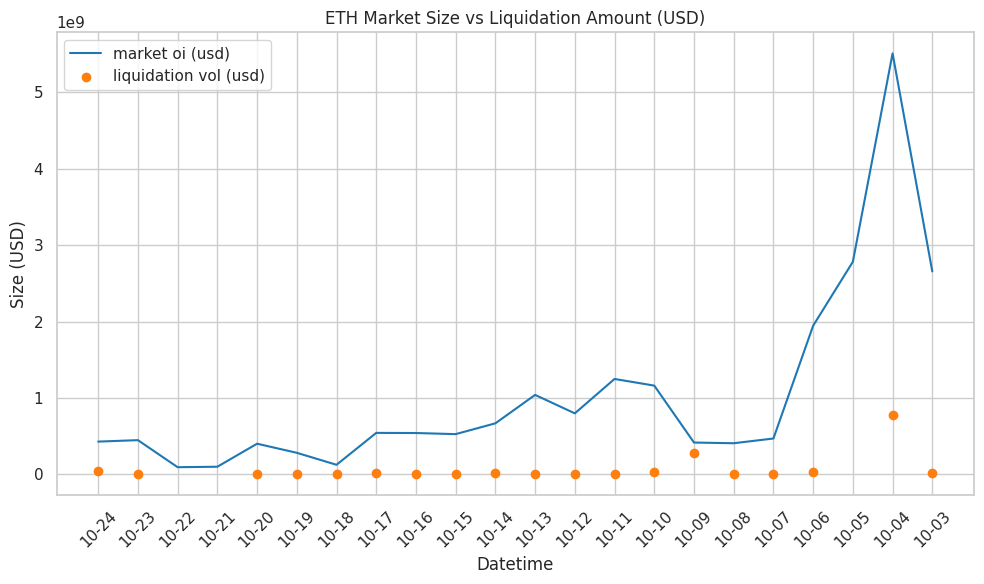

In [23]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'marketUpdateds_size_usd'
ax.plot(plot_merged_df['datetime'], plot_merged_df['marketUpdateds_size_usd'], label='market oi (usd)', color='tab:blue')

# Plot 'size_usd_abs' as scatter points
ax.scatter(plot_merged_df['datetime'], plot_merged_df['size_delta_usd_abs'], label='liquidation vol (usd)', color='tab:orange')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Size (USD)')
ax.set_title('ETH Market Size vs Liquidation Amount (USD)')
ax.legend(loc='upper left')

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

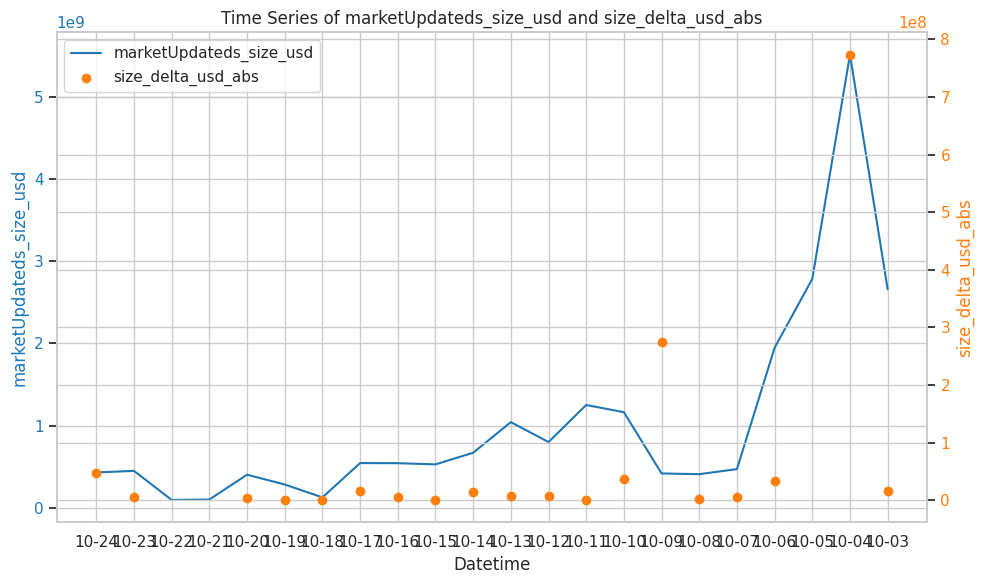

In [24]:
# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'marketUpdateds_size_usd' on the primary axis
ax1.plot(plot_merged_df['datetime'], plot_merged_df['marketUpdateds_size_usd'], label='marketUpdateds_size_usd', color='tab:blue')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('marketUpdateds_size_usd', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin axis on the secondary y-axis
ax2 = ax1.twinx()

# Plot 'size_delta_usd_abs' on the secondary axis
ax2.scatter(plot_merged_df['datetime'], plot_merged_df['size_delta_usd_abs'], label='size_delta_usd_abs', color='tab:orange')
ax2.set_ylabel('size_delta_usd_abs', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add labels and legend
ax1.set_title('Time Series of marketUpdateds_size_usd and size_delta_usd_abs')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Trade Count by Market

In [25]:
# Group by datetime, count occurrences, and pivot to create a stacked DataFrame
market_counts = (perps_v3_df
    .group_by(pl.col('marketSymbol', 'liquidation')).agg([pl.count()])
).to_pandas()

In [26]:
market_counts.head(5)

,marketSymbol,liquidation,count
0,SNX,True,105
1,BTC,False,481
2,LINK,True,72
3,LINK,False,254
4,SNX,False,487


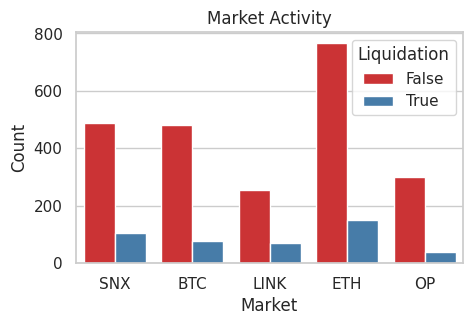

In [27]:
plt.figure(figsize=(5, 3))  # Set the figure size
sns.set(style="whitegrid")  # Set the style

g = sns.barplot(x="marketSymbol", y="count", hue="liquidation", data=market_counts, palette="Set1")

# Set labels and title
plt.xlabel("Market")
plt.ylabel("Count")
plt.title("Market Activity")

# Show the plot
plt.legend(title="Liquidation", loc="upper right")
plt.show()

### Individual Accounts (matches some numbers from [here](https://blog.synthetix.io/perps-v3-testnet-competition-a-wrap-up-rewards-breakdown/) )

In [28]:
# highest volume
(
    perps_v3_df.filter(pl.col('accounts_owner') == "0x1140321cce279b4a2158571eb377669def562ac4".lower())
    .filter(pl.col('liquidation') == False)
).select(pl.sum('size_usd_abs'))

ColumnNotFoundError: size_usd_abs

Error originated just after this operation:
DF ["datetime", "accountId", "marketSymbol", "size_delta"]; PROJECT */10 COLUMNS; SELECTION: "None"

In [ ]:
# highest trade count
(
    perps_v3_df.filter(pl.col('accounts_owner') == "0xc14baefd5631ec25c9e4d02f3253b1e59d848911".lower())
    .filter(pl.col('liquidation') == False)
).group_by(pl.col('marketSymbol')).agg([pl.count()])

marketSymbol,count
str,u32
"""LINK""",27
"""BTC""",13
"""OP""",25
"""SNX""",29
"""ETH""",21


In [ ]:
# highest liquidation vs non liquidation volume
pivot_df = (
    perps_v3_df.group_by('accounts_owner', 'liquidation').agg([pl.sum('size_usd_abs')])
    .pivot(values="size_usd_abs", index="accounts_owner", columns="liquidation")
    .fill_null(0)
    .rename({'true': 'liquidation_volume', 'false': 'trade_volume'})
)

In [ ]:
pivot_df.with_columns([(pl.col('trade_volume') - pl.col('liquidation_volume')).alias('liq_vol')]).sort(by='liq_vol', descending=False).head(10)

accounts_owner,trade_volume,liquidation_volume,liq_vol
str,f64,f64,f64
"""0x7edea644f225c0d2ff9802ddce09bb5f53f9243f""",6.0534e6,1.7211e10,-1.7205e10
"""0x8499411bff99dde9a02903008f917eea0e27b42a""",6.1415e7,1.1042e10,-1.0981e10
"""0xa9437367ffa250fc7fe1f8c3e00092259c0c569a""",1.1632e7,6.1791e9,-6.1675e9
"""0x548238c4e961e923a25da9b1859cfbf58bd03c96""",7.7335e6,5.9466e9,-5.9388e9
"""0x38ac2a0beb844291acb67026ce48ff832956d123""",2.8134e6,4.9220e9,-4.9192e9
"""0xec8dd93c481cbe0c8658f7673f16343a72af9c3d""",1.9690e7,4.6658e9,-4.6461e9
"""0x224910152ff0b9cf2dfcf1931a4866f5d336fc9c""",1.8552e6,3.4537e9,-3.4518e9
"""0xf68d2bfcecd7895bba05a7451dd09a1749026454""",8.8808e7,2.7518e9,-2.6630e9
"""0xb6bbe5a785f6cfed3f65f2ba91ad20586b00f7e6""",2.5869e6,2.5003e9,-2.4977e9


### Trader USD Value

In [ ]:
# Group by datetime, count occurrences, and pivot to create a stacked DataFrame
volume_usd_abs = (
    perps_v3_df
    .filter(pl.col('liquidation') == True)
    .with_columns([pl.col('datetime').dt.round('1d').dt.strftime('%m-%d')])
    .group_by(pl.col('datetime', 'liquidation')).agg([pl.sum('size_usd_abs')])
    .sort(by='datetime', descending=False)
).to_pandas()

In [ ]:
volume_usd_abs.head(5)

,datetime,liquidation,size_usd_abs
0,10-03,True,1.389123e+08
1,10-04,True,1.331899e+10
2,10-05,True,5.066185e+06
3,10-06,True,1.582417e+10
4,10-07,True,1.063439e+07


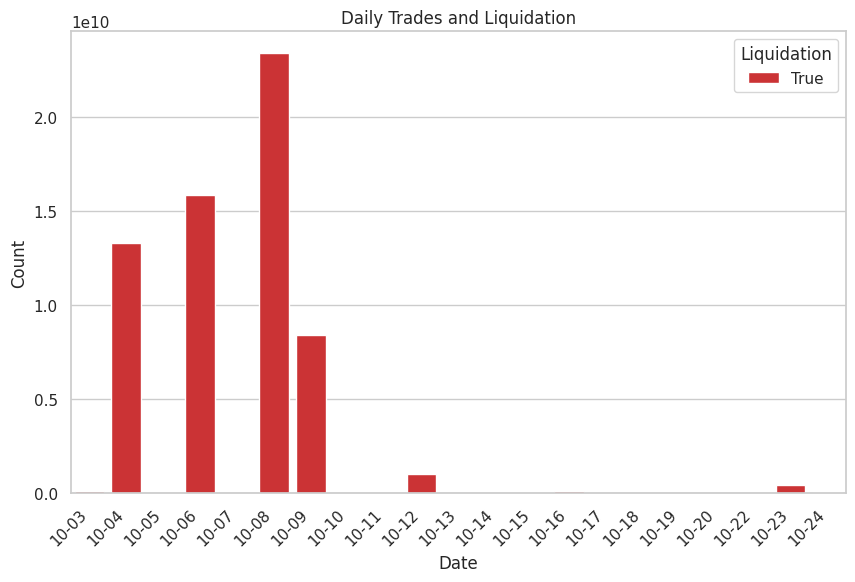

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style
sns.barplot(x="datetime", y="size_usd_abs", hue="liquidation", data=volume_usd_abs, palette="Set1")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Trades and Liquidation")

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.legend(title="Liquidation", loc="upper right")
plt.show()